# Este Notebook esta enfocado en el modelo de clasificación de XGBClassifier

In [2]:
pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   -- ------------------------------------- 5.0/72.0 MB 33.5 MB/s eta 0:00:03
   ------- -------------------------------- 13.6/72.0 MB 37.3 MB/s eta 0:00:02
   ------------- -------------------------- 24.6/72.0 MB 44.5 MB/s eta 0:00:02
   ----------------------- ---------------- 41.4/72.0 MB 54.4 MB/s eta 0:00:01
   ---------------------------- ----------- 50.9/72.0 MB 51.6 MB/s eta 0:00:01
   ---------------------------------- ----- 61.3/72.0 MB 51.8 MB/s eta 0:00:01
   ---------------------------------------  71.8/72.0 MB 52.0 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 48.5 MB/s  0:00:01


In [3]:
# 🔌 Cargar la extensión de Kedro en Jupyter
%load_ext kedro.ipython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


# Comenzamos el entrenamiento 

In [4]:
# =========================================================
# 🔌 Cargar dataset desde el catálogo
# =========================================================
df = catalog.load("Features_training_v1").copy()

# =========================================================
# 🧹 Eliminar variables que generan leakage
# =========================================================
if "RiskScore" in df.columns:
    df = df.drop(columns=["RiskScore"])
    print("✅ Columna 'RiskScore' eliminada para evitar filtración de etiquetas.")

# =========================================================
# 🎯 Separar variables predictoras y objetivo
# =========================================================
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

print("Shape X:", X.shape)
print("Distribución de clases:\n", y.value_counts(normalize=True))

[10/25/25 00:02:21] INFO     Loading data from Features_training_v1 (ParquetDataset)...        ]8;id=701239;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=613136;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

✅ Columna 'RiskScore' eliminada para evitar filtración de etiquetas.
Shape X: (984240, 4)
Distribución de clases:
 is_fraud
0    0.989999
1    0.010001
Name: proportion, dtype: float64


In [5]:
# SMOTE para oversampling
smote = SMOTE(random_state=42)

# Modelo base de XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10,   # para penalizar la clase minoritaria (fraude)
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

# Pipeline con SMOTE
pipe = Pipeline([
    ("smote", smote),
    ("model", xgb)
])

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")

print("F1 promedio (CV):", scores.mean())
print("Desviación estándar:", scores.std())

F1 promedio (CV): 0.05675133048586941
Desviación estándar: 0.0026931717483051295


              precision    recall  f1-score   support

           0      1.000     0.684     0.812    194879
           1      0.030     0.970     0.058      1969

    accuracy                          0.687    196848
   macro avg      0.515     0.827     0.435    196848
weighted avg      0.990     0.687     0.804    196848



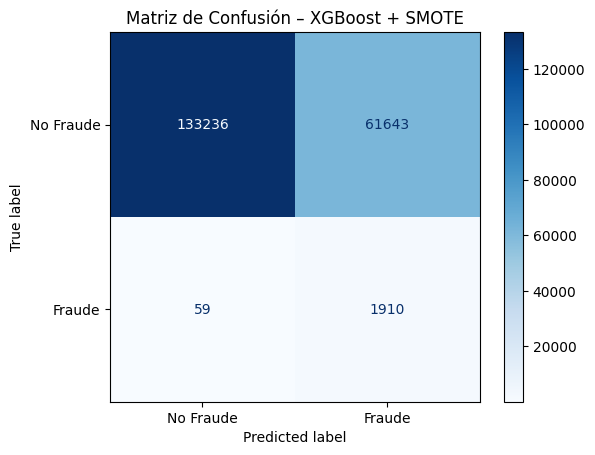

In [6]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Entrenar modelo completo
pipe.fit(X_train, y_train)

# Predicciones
y_pred = pipe.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – XGBoost + SMOTE")
plt.show()


AUC ROC: 0.928


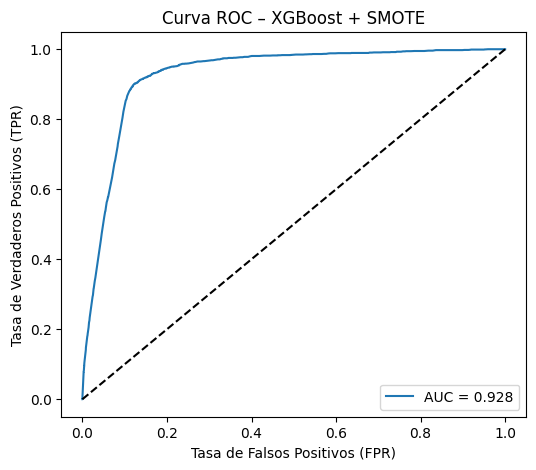

In [7]:
# Probabilidad de clase positiva
y_prob = pipe.predict_proba(X_test)[:, 1]

# Calcular AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC ROC: {auc:.3f}")

# Graficar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC – XGBoost + SMOTE")
plt.legend()
plt.show()

In [8]:
#Revisar sobreajuste Entrenamiento - Test
# === Probabilidades de clase positiva (fraude) ===
y_prob_train = pipe.predict_proba(X_train)[:, 1]
y_prob_test = pipe.predict_proba(X_test)[:, 1]

# === Calcular AUC para ambos conjuntos ===
auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

print(f"AUC entrenamiento: {auc_train:.3f}")
print(f"AUC test:          {auc_test:.3f}")


AUC entrenamiento: 0.939
AUC test:          0.930


# El modelo XGBoost, entrenado con SMOTE y ponderación de clases (scale_pos_weight=10), alcanzó un AUC de 0.939 en entrenamiento y 0.930 en test, lo que demuestra una excelente capacidad de generalización y ausencia de sobreajuste.
# El valor de AUC confirma que el modelo distingue correctamente entre transacciones fraudulentas y legítimas.
# Su comportamiento altamente sensible (recall 97 %) refleja una calibración enfocada en maximizar la detección de fraudes, con una precisión baja (3 %) esperable en este tipo de escenarios desbalanceados.
# En conjunto, el modelo presenta una discriminación sólida, generalización robusta y excelente estabilidad, siendo adecuado para tareas de detección temprana o prefiltrado de fraudes.